# EndotyPy package usage

In [1]:
import EndotypY as edy #type: ignore
import pickle
import networkx as nx

# endotypy analsysis

In [2]:
endo = edy.Endotyper()

# read in a graph from a file
path_ppi = '/Users/mathilde/Desktop/projects/Endotyping/test_data/monocyte.tsv'
#path_ppi = 'ppi_core.tsv'
#path_ppi = 'ppi_HIPPIE.tsv'
endo.import_network(path_ppi)

path_seed = '/Users/mathilde/Desktop/projects/Endotyping/test_data/ibd_risk_genes_mini.txt'
#path_seed = 'cms_genes.txt'
#read in a seed set from a file
#path_seed = 'example_seeds.txt'
endo.import_seeds(path_seed)

endo

network imported successfully
> Network contains 2866 nodes and 18725 edges

> Loaded 10 seed nodes from file: /Users/mathilde/Desktop/projects/Endotyping/test_data/ibd_risk_genes_mini.txt
seeds imported successfully


In [3]:
#prepare RWR
endo.prepare_rwr(r=0.8)

Preparing RWR...
['FCN1', 'S100A3', 'PTPN22', 'IL2RA', 'EBF1', 'HNF4A', 'NKX2-3']
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 3/3 [00:00<00:00, 133.34it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 15/15 [00:00<00:00, 340078.70it/s]

Optimal neighborhood size found at k=40 with 1 cluster(s).


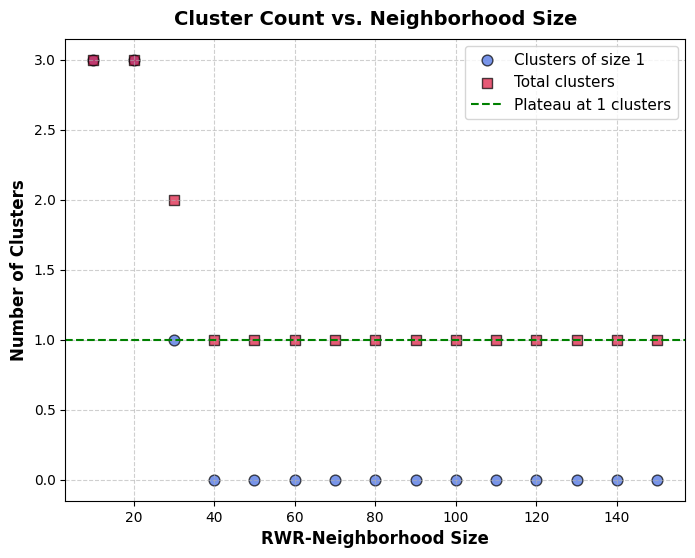

1 Seed clusters identified


{'cluster_seed_1': ['NOD2', 'LRRK2', 'CARD9']}

In [4]:
#explore the seed clusters
endo.explore_seed_clusters(scaling=True, k=150)

In [5]:
endo.extract_disease_module(seed_cluster_id = 1, scaling=True, k=40)

Using seed cluster ID 1 with 3 seeds
Connected module extracted with 43 nodes and 67 edges


In [6]:
endo.define_local_neighborhood(scaling=True, neighbor_percentage=1)

Running RWR for seed genes: 100%|██████████| 43/43 [00:00<00:00, 158.62it/s]


In [7]:
endo.annotate_local_neighborhood(enrichr_lib='Reactome_Pathways_2024',
                                 organism='Human',
                                 sig_threshold=0.05,
                                 force_download=False)

Loading Reactome_Pathways_2024 term library from cache...
Annotating local neighborhoods using Reactome_Pathways_2024 library...


In [8]:
endo.define_kl_endotypes(distance_metric='jaccard',linkage_method='complete',alpha=0.05)

--- Starting Analysis Pipeline ---
Linkage matrix computed using method: complete and distance metric: jaccard
Tree decomposition completed with alpha_local=0.05 and sibling_alpha=0.05

--- Analysis Complete ---

Algorithm found 6 clusters.
  - Cluster 0 (root: N52): 2 samples
  - Cluster 1 (root: N55): 9 samples
  - Cluster 2 (root: N56): 6 samples
  - Cluster 3 (root: N58): 2 samples
  - Cluster 4 (root: N69): 4 samples
  - Cluster 5 (root: N78): 18 samples


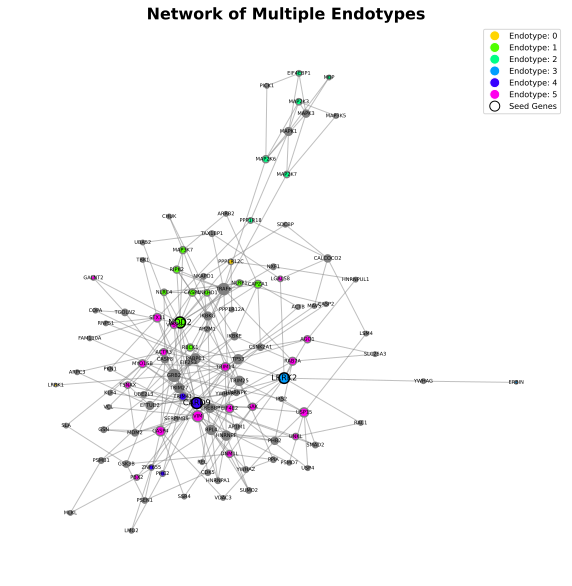

In [9]:
endo.plot_endotypes(node_size='degree', path_length=8)

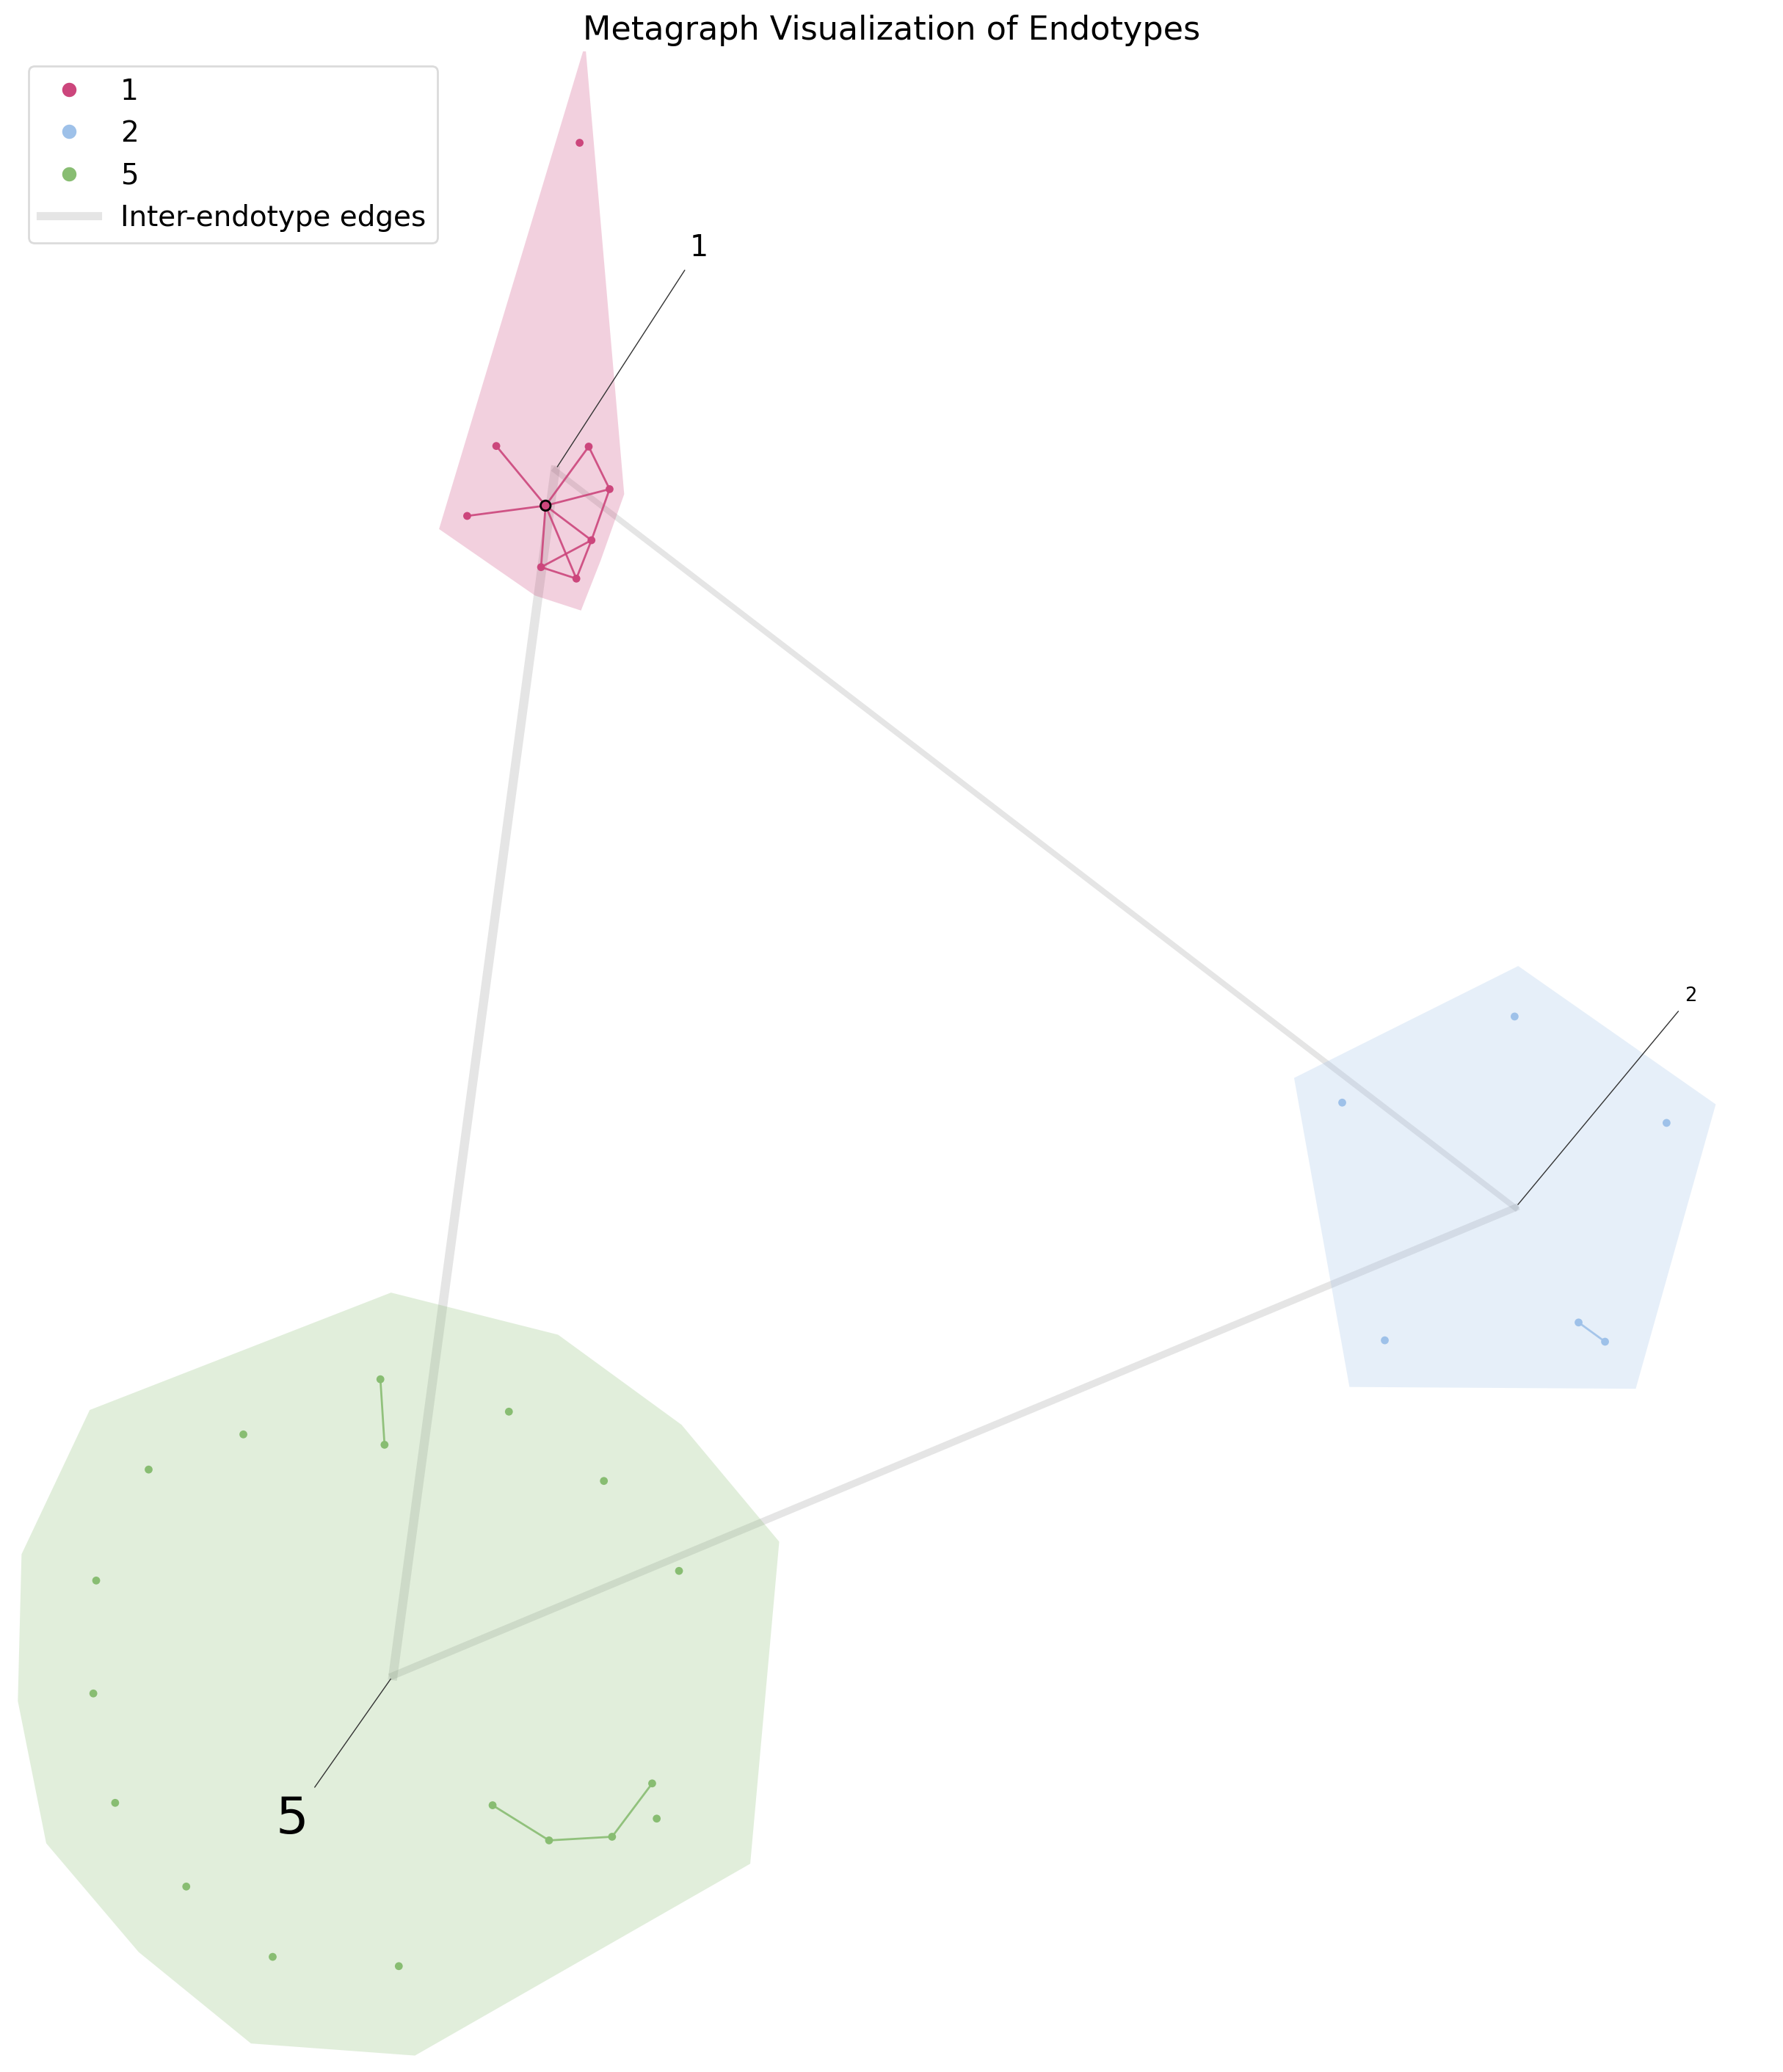

In [10]:
endo.plot_endotypes_metagraph(filter_size_endotypes=True, node_size=15)

In [13]:
endo.plot_endotype_grid(node_size='degree', path_length=3,enrichr_lib='Reactome_Pathways_2024',top_terms=10)

Loading Reactome_Pathways_2024 term library from cache...


2026-02-17 13:59:40,924 [ERROR] No hits returned for all input gene sets!


#### MDS of feature matrix

In [12]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
import plotly.express as px
import plotly.graph_objects as go

feat_mat = endo.feature_matrix

# Get endotype labels for coloring
# endo.endotypes returns a tuple (dict_mapping, dict_clusters)
# Extract the mapping dictionary and get labels in the same order as the feature matrix
endotype_mapping = endo.endotypes[0]
endotype_labels = pd.Series([endotype_mapping[gene] for gene in feat_mat.index])

# Convert feature matrix to numpy array
X = np.array(feat_mat)

# Compute distance matrix (use same metric as clustering - 'jaccard' in this case)
distance_matrix = pairwise_distances(X, metric='jaccard')

# MDS parameters
n_components = 3  # Set to 2 for 2D plot, 3 for 3D plot
random_state = 42

# Plot dimensions (in pixels)
plot_width = 1000
plot_height = 600

# Perform MDS on the distance matrix (use dissimilarity='precomputed')
mds = MDS(n_components=n_components, random_state=random_state, dissimilarity='precomputed')
mds_result = mds.fit_transform(distance_matrix)

# Create DataFrame for plotting
if n_components == 2:
    mds_df = pd.DataFrame(
        data=mds_result,
        columns=['MDS1', 'MDS2']
    )
    mds_df['Endotype'] = endotype_labels.astype(str)
    mds_df['Gene'] = feat_mat.index
    
    # Plot 2D MDS
    fig_mds = px.scatter(
        mds_df,
        x='MDS1',
        y='MDS2',
        color='Endotype',
        hover_data=['Gene'],
        title='2D MDS of Distance Matrix (Jaccard)',
        width=plot_width,
        height=plot_height
    )
elif n_components == 3:
    mds_df = pd.DataFrame(
        data=mds_result,
        columns=['MDS1', 'MDS2', 'MDS3']
    )
    mds_df['Endotype'] = endotype_labels.astype(str)
    mds_df['Gene'] = feat_mat.index
    
    # Plot 3D MDS
    fig_mds = px.scatter_3d(
        mds_df,
        x='MDS1',
        y='MDS2',
        z='MDS3',
        color='Endotype',
        hover_data=['Gene'],
        title='3D MDS of Distance Matrix (Jaccard)',
        width=plot_width,
        height=plot_height
    )

fig_mds.show()


/Users/mathilde/Desktop/projects/Endotyping/ENDOTEST/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2459: DataConversionWarning:

Data was converted to boolean for metric jaccard

/Users/mathilde/Desktop/projects/Endotyping/ENDOTEST/lib/python3.11/site-packages/sklearn/manifold/_mds.py:744: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.

/Users/mathilde/Desktop/projects/Endotyping/ENDOTEST/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning:

The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.

/Users/mathilde/Desktop/projects/Endotyping/ENDOTEST/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning:

The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.

